In [82]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder

# Cargar los datos
data = pd.read_csv('data.csv')

# A la columna de Kilómetros le sacamos el km y lo convertimos a número
data['Kilómetros'] = data['Kilómetros'].str.replace(' km', '').str.replace(',', '').astype(int)

data = data[data['Marca'] == 'Toyota']

# Definir las características (features) y el objetivo (target)
X = data[['Kilómetros', 'Edad', 'Modelo']]
y = data['Precio']

# Visualizar los primeros registros para asegurarnos de que se han cargado correctamente
print(data.head())

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_max = y_train.max()
y_test = y_test / y_train_max
y_train = y_train / y_train_max

# Codificar la columna de modelos utilizando target encoding
encoder = TargetEncoder(cols=['Modelo'])
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

X_train_max = X_train.max()
X_train_min = X_train.min()
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)


# Convertir las características a tensores
X_train = torch.tensor(X_train.values).float()
y_train = torch.tensor(y_train.values).float()
X_test = torch.tensor(X_test.values).float()
y_test = torch.tensor(y_test.values).float()

     Unnamed: 0   Marca   Modelo  Kilómetros        Precio  Edad
895         895  Toyota  4Runner      283000  27500.000000  32.0
896         896  Toyota  4Runner      340000  19000.000000  28.0
897         897  Toyota  4Runner      370000  10900.000000  27.0
898         898  Toyota  4Runner      199000  15865.384615  30.0
899         899  Toyota  4Runner      420000  12500.000000  28.0


Epoch 1/100, Train Loss: 0.012198577111121267, Test Loss: 0.0062322662367175026
Epoch 2/100, Train Loss: 0.0051532033588349195, Test Loss: 0.003709785989485681
Epoch 3/100, Train Loss: 0.003592645904670159, Test Loss: 0.0028792909191300473
Epoch 4/100, Train Loss: 0.0031365819352989397, Test Loss: 0.0025556754553690553
Epoch 5/100, Train Loss: 0.00267769482403916, Test Loss: 0.0022993421686502793
Epoch 6/100, Train Loss: 0.0023983943780573704, Test Loss: 0.002168625263342013
Epoch 7/100, Train Loss: 0.002228237943199929, Test Loss: 0.002028465135178218
Epoch 8/100, Train Loss: 0.0020926468763112402, Test Loss: 0.001883026658712576
Epoch 9/100, Train Loss: 0.0019999369372574924, Test Loss: 0.0018514384767816712
Epoch 10/100, Train Loss: 0.0019349298721256976, Test Loss: 0.0017823084781412035
Epoch 11/100, Train Loss: 0.0018925319867169794, Test Loss: 0.0017981984128709882
Epoch 12/100, Train Loss: 0.001857148240863656, Test Loss: 0.0017539645778015256
Epoch 13/100, Train Loss: 0.0018082

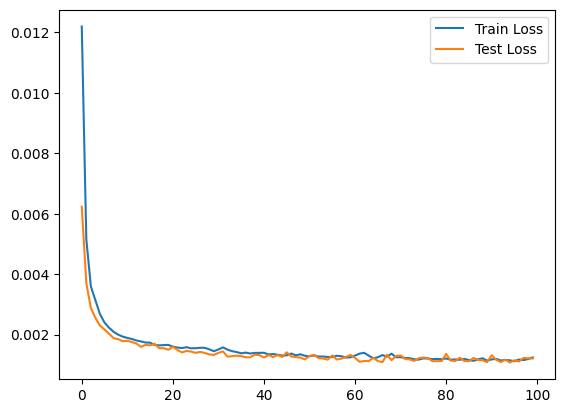

In [84]:
# Definir el tamaño del lote
batch_size = 64

# Crear un DataLoader para los datos de entrenamiento
train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Crear un DataLoader para los datos de prueba
test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# Definir la arquitectura de la red neuronal
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)
    
# Crear una instancia de la red neuronal
model = NeuralNetwork().to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenar la red neuronal
num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            test_loss += loss.item()
        test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")

# Visualizar la pérdida durante el entrenamiento
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

In [85]:
# Ver el error
model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(device))
    loss = criterion(y_pred, y_test.unsqueeze(1).to(device))
    print(f"Test Loss: {loss.item()}")
    print(f"Error: {loss.item() * y_train_max}")

Test Loss: 0.0012120888568460941
Error: 187.8737728111446


In [90]:
X_new = pd.DataFrame({
    'Kilómetros': [0],
    'Edad': [50],
    'Modelo': ['SW4']
})
X_new = encoder.transform(X_new)
X_new = torch.tensor(X_new.values).float().to(device)
y_pred = model(X_new)
y_pred = y_pred.item() * y_train_max
print(f"El precio estimado del coche es: {y_pred:.2f} €")

El precio estimado del coche es: 2772223.22 €
